# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [4]:
import pandas as pd

In [14]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


In [3]:
df

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00
...,...
2011-11-13,229378.01
2011-11-20,221870.29
2011-11-27,210741.76


# Data analysis

First, explore the time series.

## Plot time series

<AxesSubplot: xlabel='week'>

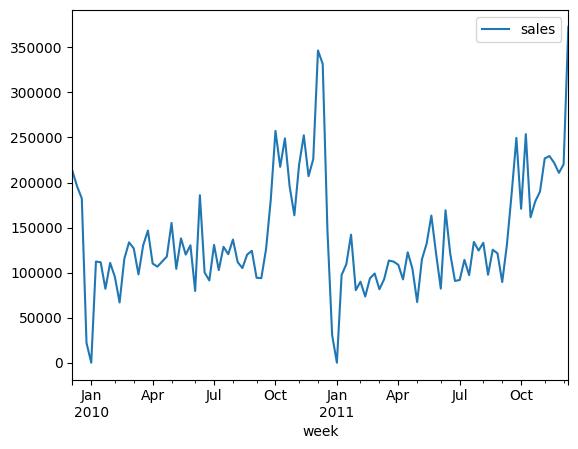

In [4]:
df.plot()

Doesn't look like there's missing data  
Chacking for seasonality:

<AxesSubplot: xlabel='week'>

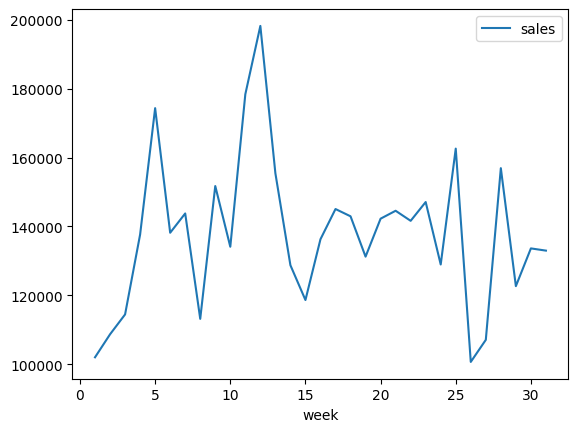

In [5]:
# daily seasonality
df.groupby(df.index.day).mean().plot()

<AxesSubplot: xlabel='week'>

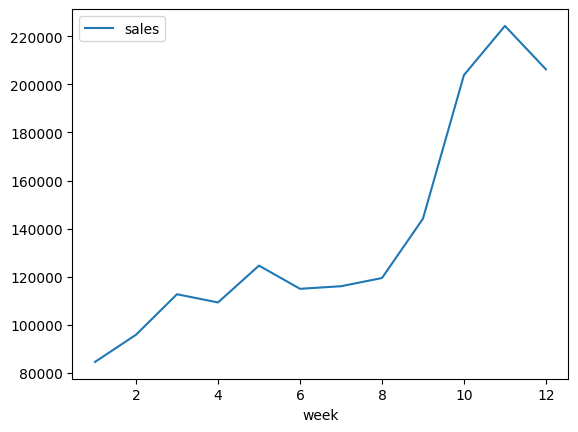

In [6]:
# monthly seasonality
df.groupby(df.index.month).mean().plot()

There's daily and monthly seasonality.

## Missing data

Check if there are missing values in the time series.

In [7]:
df.asfreq('W').isnull().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

## Seasonality

Does the time series show any obvious seasonal pattern?

# Feature engineering

Now, let's begin to tabularize the data.

In [3]:
from feature_engine.creation import CyclicalFeatures

In [12]:
def add_features(df):
    
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    #df['day_week'] = df.index.day_of_week
    #df['weekend'] = df.index.day_of_week.apply(lambda x: 0 if x<5 else 1)
    
    # lag features
    df['lag1'] = df.sales.shift(1)
    df['lag4'] = df.sales.shift(4)
    
    # window features -> avg last 2/4 weeks
    df['windowlast2weeks'] = df.sales.rolling(window='14D').mean().shift(freq='1W')
    df['windowlast4weeks'] = df.sales.rolling(window='30D').mean().shift(freq='1W')
    
    # cyclic features
    cyclic = CyclicalFeatures(variables=['year', 'month', 'day'], drop_original=False)
    df = cyclic.fit_transform(df)
    
    return df

In [15]:
df = add_features(df)
df

,sales,year,month,day,lag1,lag4,windowlast2weeks,windowlast4weeks,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos
week,,,,,,,,,,,,,,
2009-12-06,213000.35,2009,12,6,NaN,NaN,NaN,NaN,-6.248776e-03,0.999980,-2.449294e-16,1.000000,0.937752,0.347305
2009-12-13,195810.04,2009,12,13,213000.35,NaN,213000.350,213000.350000,-6.248776e-03,0.999980,-2.449294e-16,1.000000,0.485302,-0.874347
2009-12-20,182396.74,2009,12,20,195810.04,NaN,204405.195,204405.195000,-6.248776e-03,0.999980,-2.449294e-16,1.000000,-0.790776,-0.612106
2009-12-27,22007.77,2009,12,27,182396.74,NaN,189103.390,197069.043333,-6.248776e-03,0.999980,-2.449294e-16,1.000000,-0.724793,0.688967
2010-01-03,0.00,2010,1,3,22007.77,213000.35,102202.255,153303.725000,-3.124403e-03,0.999995,5.000000e-01,0.866025,0.571268,0.820763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,229378.01,2011,11,13,226770.53,161438.54,208402.365,202212.576000,-2.449294e-16,1.000000,-5.000000e-01,0.866025,0.485302,-0.874347
2011-11-20,221870.29,2011,11,20,229378.01,179106.07,228074.270,197345.470000,-2.449294e-16,1.000000,-5.000000e-01,0.866025,-0.790776,-0.612106
2011-11-27,210741.76,2011,11,27,221870.29,190034.20,225624.150,209431.820000,-2.449294e-16,1.000000,-5.000000e-01,0.866025,-0.724793,0.688967


In [11]:
(221870.29+210741.76) /2

216306.02500000002

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [17]:
df = df.dropna().reset_index(drop=True)
train = df.iloc[:-1]
test = df.iloc[-1]

In [33]:
len(train), len(pd.DataFrame(test).T)

(101, 1)

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

## Machine Learning